In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import warnings
import fbprophet
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

Importing plotly failed. Interactive plots will not work.


In [35]:
import matplotlib.dates as mdates
from matplotlib import rcParams

# Import Data






In [7]:
data = pd.read_csv('./dataset/ad_table.csv')

# Data Exploration

In [8]:
data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [28]:
data.tail()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
2110,2015-11-18,78111,1326,37,1.01,553.36,ad_group_40
2111,2015-11-19,79857,1413,34,1.00,840.72,ad_group_40
2112,2015-11-20,75695,1332,35,1.09,468.95,ad_group_40
2113,2015-11-21,73761,1336,36,1.11,437.03,ad_group_40
2114,2015-11-22,77907,1391,34,0.99,409.30,ad_group_40


In [4]:
data.dtypes

date                   object
shown                   int64
clicked                 int64
converted               int64
avg_cost_per_click    float64
total_revenue         float64
ad                     object
dtype: object

In [9]:
data['date'] = pd.to_datetime(data['date'])

In [10]:
data.dtypes

date                  datetime64[ns]
shown                          int64
clicked                        int64
converted                      int64
avg_cost_per_click           float64
total_revenue                float64
ad                            object
dtype: object

In [11]:
data.shape

(2115, 7)

In [12]:
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [13]:
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


Revenue cannot be negative

In [14]:
len(data[data['total_revenue'] < 0])

4

In [15]:
#Remove those
data = data.query('total_revenue>=0')

Also, clicked should be >= shown and converted should be >= clicked. Let's see:

In [16]:
len(data.query('shown<clicked | clicked<converted'))

0

In [17]:
len(data.query('shown==0'))

13

In [18]:
# remove zero impression data
data = data.query('shown>0')

In [19]:
len(data.query('clicked==0'))

7

In [20]:
# remove zero clicked data
data = data.query('clicked>0')

In [21]:
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,68853.852702,3088.744142,127.822573,1.387661,1989.242257
std,48799.535713,3792.468317,234.394500,0.746035,3958.838731
min,7494.000000,187.000000,0.000000,0.080000,0.000000
25%,28446.000000,756.500000,18.000000,0.780000,244.765000
50%,54569.000000,1413.000000,42.000000,1.410000,561.070000
75%,100395.500000,3413.500000,106.000000,1.920000,1634.895000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


We could spend more time looking at the data, but overall things seem to make sense now.

Q: If you had to identify the 5 best ad groups, which ones would be? Which metric did you choose to identify the best ones? Why? Explain the pros of your metric as well as the possible cons. From a business perspective, choosing that metric implies that you are focusing on what?

There are obviously tons of ad related metric. And they are all plausible and useful in different situations, depending on the main business focus of a given company. A few examples are:

1 Click-through-rate (CTR), # of clicks/ # of impressions, i.e. of all people seeing the ad, how many click on it? Pros: as discussed extensively in this course case studies, it is great to identify demand from users. Also, since it only takes into account what the user does after seeing the ad, it can be easily estimated and allows to test and improve ad characteristics to maximize the number of users coming to the site Cons: It has no information about what the user does once they come to the site as well as costs. A very high CTR is not that useful is no one of those users converts. It can also easily be tricked via click-bait ads. This metric is purely growth-based when the goal is to bring users to the site

2 Conversion rate (CR), # of conversions/ # of impressions, i.e. of all people seeing the ad, how many people end up becoming customers? Pros: Fixes most of CTR issues. After all, the goal of an ad is to get customers, and this is what this metric represents. Cons: It has no information about costs. Also, conversion on the site highly depends on the product. An ad could be great in capturing demand, but if the product is bad, no one converts. Finally, how to link conversion to an ad click is pretty messy, conversion might happen after a long time, might happen after multiple visits through different channels, etc. This metric combines both growth and product.

3 Profits, revenue from conversions - ad costs Pros: Very concrete and business driven. Am I making money via ads? Cons: Same as CR, hard to define revenue from an ad, not only there are the issues described above, but here you would need to predict user lifetime value to see if an ad is profitable. Also, it only considers users after they click on the ad. It has no information about the top of the funnel, i.e. how many users see the ad and choose to not click. This metric focuses on the business/product side, but it is hardly useful from a growth standpoint. It is typically used by very large companies whose main goal is being profitable.
For this exercise, let’s look into profits and CTR. We will pick the top 5 ads based on CTR as long as profits are above a certain threshold. In plain English, that means we want the ads with the highest growth potential after removing the ads that would make us go broken.

In [22]:
#Let's get CTR and profits per ad group on an avg
data_rank = data.groupby('ad').apply(
             lambda x: pd.Series({
                       'CTR': (x['clicked']/x['shown']).mean(),
                       'profits': (x['total_revenue']-x['clicked']*x['avg_cost_per_click']).mean(),
                       'count': x['shown'].mean()
  })).reset_index()

In [23]:
data_rank.head()

,ad,CTR,profits,count
0,ad_group_1,0.039003,-1901.937547,69345.566038
1,ad_group_10,0.014175,-1650.159615,117701.365385
2,ad_group_11,0.063575,-1346.640408,19448.979592
3,ad_group_12,0.061022,-1194.148431,29145.549020
4,ad_group_13,0.085635,-3573.196275,161519.176471


In [24]:
data_rank.describe()

,CTR,profits,count
count,40.000000,40.000000,40.000000
mean,0.046767,-3727.781833,68765.870284
std,0.032375,7316.360934,49241.400530
min,0.002056,-42659.834528,8461.096154
25%,0.014243,-3723.092961,28728.946078
50%,0.042851,-1270.394420,54094.296807
75%,0.081602,-237.768783,98321.619034
max,0.098996,1027.480000,174986.075472


In [25]:
data_rank.sort_values(by = ['CTR','profits'],ascending = False).head()

,ad,CTR,profits,count
9,ad_group_18,0.098996,-7708.119808,89124.346154
22,ad_group_3,0.094987,-42659.834528,169248.924528
10,ad_group_19,0.094188,-3460.419038,19506.884615
18,ad_group_26,0.090972,-9630.303962,72090.660377
20,ad_group_28,0.089191,-2644.280943,19886.339623


Text(0, 0.5, 'CTR')

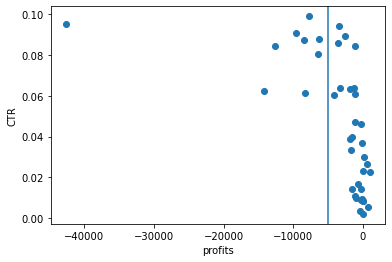

In [26]:
#Let's plot them
plt.scatter(data_rank['profits'], data_rank['CTR'])
plt.axvline(x=-5000)
plt.xlabel('profits')
plt.ylabel('CTR')

Based on the plot, we can define as threshold for profitability -5K. We will remove all ads below that, and then find the ads with the highest CTR among the remaining ones. Note that here we are considering short term revenue from the ad, and we are expecting that number to be negative. An ad should be positive when taking into account a user life time value (as usual, lifetime -> 1 yr).

In [27]:
#Remove ads that are making us lose too much money and find top 5 based on CTR among the other ones
print(data_rank.query('profits > -5000').sort_values('CTR', ascending=False).head(5))

             ad       CTR      profits          count
10  ad_group_19  0.094188 -3460.419038   19506.884615
20  ad_group_28  0.089191 -2644.280943   19886.339623
4   ad_group_13  0.085635 -3573.196275  161519.176471
27  ad_group_34  0.084257 -1189.270000   35371.622642
35   ad_group_5  0.063862 -3233.796538   52406.461538


Q: For each group, predict how many ads will be shown on Dec, 15

The most common ways to do this are either using gam or using some time series package. In this case, we will do via the time series package prophet.

In [33]:
#Let's firstly take just one ad_group and do it manually for that one as an example. Then, we will apply it to all others
data_ad1 =data.query('ad=="ad_group_1"')[["date", "shown"]]

Text(0.5, 1.0, 'Ad group 1')

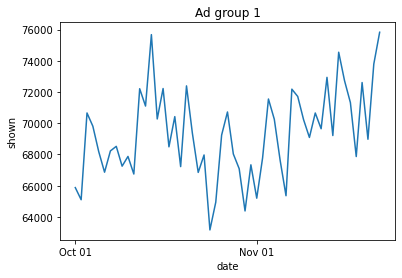

In [36]:
#plot
g=sns.lineplot(x="date", y="shown", data=data_ad1)
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title("Ad group 1")

In [37]:
#Let's build time series using prophet. From previous plots, time series appear pretty straightforward and flattish. Default values should do fine
  
#change column names and index
data_ad1['ds'] = data_ad1['date']
data_ad1.rename({'shown': 'y'}, axis=1, inplace=True)
data_ad1.set_index('date', inplace=True)
 
#build the model
ts = fbprophet.Prophet()
ts.fit(data_ad1)
  
#make predictions until Dec 15. This is the number of days for which we need a prediction to get to Dec 15

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


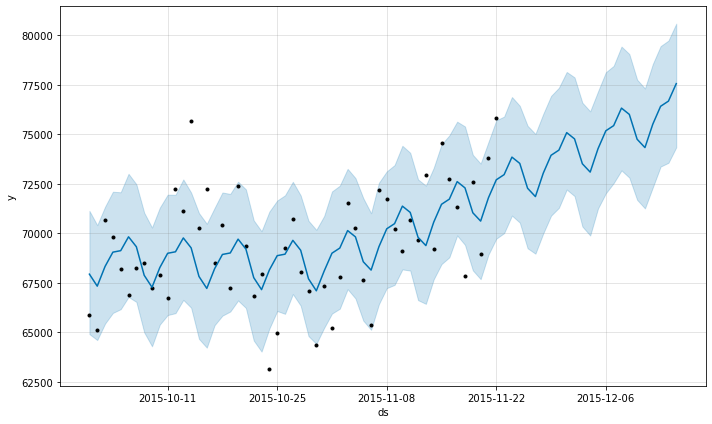

In [39]:
days_predictions = (pd.to_datetime("2015-12-15")-data_ad1['ds'].max()).days
future_data = ts.make_future_dataframe(periods = days_predictions)
predictions = ts.predict(future_data)
  
#let's plot them
ts.plot(predictions);

In [46]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-01,68723.100210,64906.535587,71131.760796,68723.100210,68723.100210,-789.278575,-789.278575,-789.278575,-789.278575,-789.278575,-789.278575,0.0,0.0,0.0,67933.821634
1,2015-10-02,68714.995063,64604.986195,70408.278039,68714.995063,68714.995063,-1386.618392,-1386.618392,-1386.618392,-1386.618392,-1386.618392,-1386.618392,0.0,0.0,0.0,67328.376671
2,2015-10-03,68706.889917,65437.792723,71340.222299,68706.889917,68706.889917,-382.697393,-382.697393,-382.697393,-382.697393,-382.697393,-382.697393,0.0,0.0,0.0,68324.192524
3,2015-10-04,68698.784770,65976.760504,72097.796362,68698.784770,68698.784770,346.583014,346.583014,346.583014,346.583014,346.583014,346.583014,0.0,0.0,0.0,69045.367784
4,2015-10-05,68690.679623,66165.212739,72070.572661,68690.679623,68690.679623,430.141442,430.141442,430.141442,430.141442,430.141442,430.141442,0.0,0.0,0.0,69120.821065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2015-12-11,75713.431140,71255.135946,77313.619334,75287.982792,76171.616210,-1386.618392,-1386.618392,-1386.618392,-1386.618392,-1386.618392,-1386.618392,0.0,0.0,0.0,74326.812747
72,2015-12-12,75890.236859,72313.964843,78544.544628,75437.882987,76377.306482,-382.697393,-382.697393,-382.697393,-382.697393,-382.697393,-382.697393,0.0,0.0,0.0,75507.539466
73,2015-12-13,76067.042579,73368.845081,79451.463012,75594.295785,76593.915642,346.583014,346.583014,346.583014,346.583014,346.583014,346.583014,0.0,0.0,0.0,76413.625593
74,2015-12-14,76243.848299,73558.633383,79730.220076,75728.166265,76817.575217,430.141442,430.141442,430.141442,430.141442,430.141442,430.141442,0.0,0.0,0.0,76673.989741


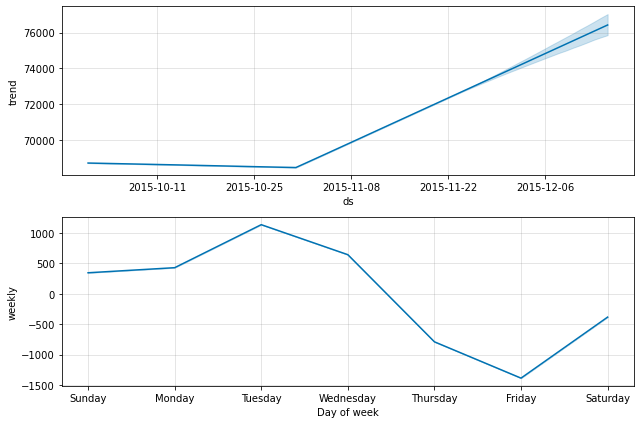

In [40]:
#and plot the series component
ts.plot_components(predictions);

We can see that there is some (very very small) weekly variation. Most importantly, the time serie overall is pretty flat in October and starts going up in Nov. Predictions for Dec 15 tend to be up given that the model assumes the time serie keeps following its most recent trend. Obviously, this would be much more useful with yearly data, so we would be able to capture yearly seasonality.

Let’s now do it for all the ad groups and get the predictions.

In [42]:
#data set to store results
predictions_all_groups = pd.DataFrame({'ad_group':data['ad'].unique(),
                                           'date': pandas.to_datetime("2015-12-15")})

In [43]:
predictions_all_groups.head()

,ad_group,date
0,ad_group_1,2015-12-15
1,ad_group_2,2015-12-15
2,ad_group_3,2015-12-15
3,ad_group_4,2015-12-15
4,ad_group_5,2015-12-15


In [45]:
#We will do it via a for loop through all the ad groups
prediction_dec_15 = [] 
for level in predictions_all_groups.ad_group:
     
     #subset data, only keep 1 ad group and columns needed
     tmp = data.loc[data['ad']==level][["date", "shown"]]
#change column names and index
     tmp['ds'] = tmp['date']
     tmp.rename({'shown': 'y'}, axis=1, inplace=True)
     tmp.set_index('date', inplace=True)
     
     #build the model
     ts_tmp = fbprophet.Prophet()
     ts_tmp.fit(tmp)
     
     #make predictions until Dec 15. This is the number of days for which we need a prediction to get to Dec 15
     days_predictions_tmp = (pd.to_datetime("2015-12-15")-tmp['ds'].max()).days
     future_data_tmp = ts_tmp.make_future_dataframe(periods = days_predictions_tmp)
     predictions_tmp = ts_tmp.predict(future_data_tmp)
     
     #store results for the last day, i.e. Dec 15 prediction
     prediction_dec_15.append(round(predictions_tmp['yhat'].iat[-1]))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [47]:
predictions_all_groups['predictions'] = prediction_dec_15
print(predictions_all_groups)

       ad_group       date  predictions
0    ad_group_1 2015-12-15      77558.0
1    ad_group_2 2015-12-15      50305.0
2    ad_group_3 2015-12-15     152888.0
3    ad_group_4 2015-12-15      94679.0
4    ad_group_5 2015-12-15      54750.0
5    ad_group_6 2015-12-15      40587.0
6    ad_group_7 2015-12-15      56988.0
7    ad_group_8 2015-12-15      47171.0
8    ad_group_9 2015-12-15     124642.0
9   ad_group_10 2015-12-15     127043.0
10  ad_group_11 2015-12-15      19964.0
11  ad_group_12 2015-12-15      28000.0
12  ad_group_13 2015-12-15     162073.0
13  ad_group_14 2015-12-15       8715.0
14  ad_group_15 2015-12-15      15773.0
15  ad_group_16 2015-12-15      30494.0
16  ad_group_17 2015-12-15     134101.0
17  ad_group_18 2015-12-15      89749.0
18  ad_group_19 2015-12-15      19889.0
19  ad_group_20 2015-12-15     120417.0
20  ad_group_21 2015-12-15      28320.0
21  ad_group_22 2015-12-15      26866.0
22  ad_group_23 2015-12-15      48616.0
23  ad_group_24 2015-12-15      37394.0


Q: Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down

The simplest way to answer this is to build a linear regression for each ad group. Cost_per_click will be the y value and the x axis is days as a number (1,2,3,etc). We will then check the coefficient of the regression: Positive and significant coefficient -> going up Negative and significant coefficient -> going down Non-significant coefficient -> flat

Text(0.5, 1.0, 'Avg Cost per Click')

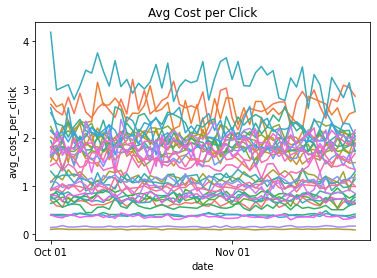

In [48]:
#firstly let's plot them to get a sense of whether cost per click is going up or not in general
g=sns.lineplot(x="date", y="avg_cost_per_click",hue="ad", data=data, legend="")
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title("Avg Cost per Click") 

It is pretty messy, but overall things seem pretty flat.

In [58]:
data_ad1_cost= data.query('ad=="ad_group_1"')[["date", "avg_cost_per_click"]]

In [59]:
data_ad1_cost['day'] = (data_ad1_cost['date'] - data_ad1_cost['date'].min()).dt.days

Text(0, 0.5, 'cost per click')

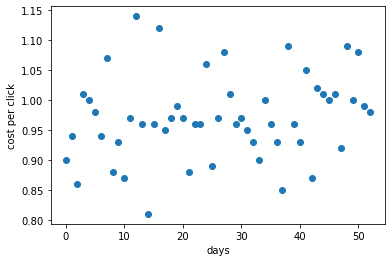

In [60]:
plt.scatter(data_ad1_cost['day'],data_ad1_cost['avg_cost_per_click'] )
plt.xlabel('days')
plt.ylabel('cost per click')

In [63]:
data_ad1_cost.head()

,date,avg_cost_per_click,day
0,2015-10-01,0.90,0
1,2015-10-02,0.94,1
2,2015-10-03,0.86,2
3,2015-10-04,1.01,3
4,2015-10-05,1.00,4


Text(0.5, 1.0, 'Avg Cost per Click')

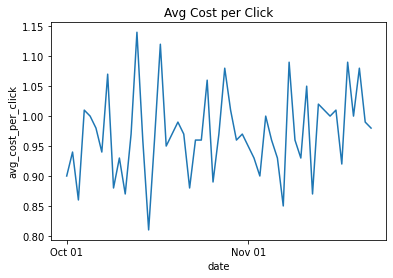

In [64]:
g=sns.lineplot(x="date", y="avg_cost_per_click", data=data_ad1_cost, legend="")
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title("Avg Cost per Click")

from the above  plots, there is no up/down trend, pretty flat

In [49]:
import statsmodels.api as sm
#build all linear regressions via a for loop
 
#empty vectors
coefficient = []
p_value = []
 
#for loop over all ad groups
for level in data['ad'].unique():
  
  #subset dataset and keep variables we care about
  data_reg = data.loc[data['ad']==level][["date", "avg_cost_per_click"]]
  #replace dates with numbers. 0 is the minimum date, 1 is minimum date + 1 day and so on
  data_reg['date'] = (data_reg['date'] - data_reg['date'].min()).dt.days
  #add intercept
  data_reg['intercept'] = 1
  
  #build the regression
  lr = sm.OLS(data_reg['avg_cost_per_click'],data_reg.drop('avg_cost_per_click', axis=1)).fit()
  #save coefficient and p-value
  coefficient.append(lr.params[0])
  p_value.append(lr.pvalues[0])
 
 
#put all together in a datframe
lr_output = pd.DataFrame({
                  'ad_group': data['ad'].unique(),
                  'coefficients': coefficient,
                  'p_value': p_value})
 
#classify based on the rule described above. we use Bonferroni rule for significance
lr_output['cluster'] = np.where((lr_output['coefficients']>0) & (lr_output['p_value']<0.05/40), 'going_up',
                                np.where((lr_output['coefficients']<0) & (lr_output['p_value']<0.05/40), 'going_down',
                                         'flat'))
  
print(lr_output)

       ad_group  coefficients   p_value cluster
0    ad_group_1      0.000926  0.145429    flat
1    ad_group_2     -0.000006  0.991095    flat
2    ad_group_3      0.002445  0.255564    flat
3    ad_group_4     -0.000577  0.804445    flat
4    ad_group_5     -0.001018  0.440261    flat
5    ad_group_6     -0.001734  0.077129    flat
6    ad_group_7     -0.002569  0.120068    flat
7    ad_group_8     -0.002689  0.026231    flat
8    ad_group_9      0.000044  0.434626    flat
9   ad_group_10     -0.000161  0.861238    flat
10  ad_group_11      0.000490  0.655742    flat
11  ad_group_12      0.000861  0.494787    flat
12  ad_group_13      0.000198  0.874992    flat
13  ad_group_14     -0.000776  0.168030    flat
14  ad_group_15      0.000406  0.533287    flat
15  ad_group_16     -0.000595  0.280798    flat
16  ad_group_17     -0.000027  0.894071    flat
17  ad_group_18      0.000625  0.691426    flat
18  ad_group_19     -0.002980  0.139845    flat
19  ad_group_20      0.000685  0.467957 

In [65]:
print(lr_output['cluster'].value_counts())

flat    40
Name: cluster, dtype: int64


Looks like everything is flat. W/o using the Bonferroni correction (i.e. had we chosen a less aggressive p-value threshold), we would have likely found some significant ads. Also, via a linear regression, we are looking at the overall trend. That is, old data points weigh just as much as the most recent ones. Had we focused only on the most recent data, we obviously might have found different results.